# Red wine quality prediction

Plot different hyperparameters against the loss function.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, DataLoader
import os

from sklearn.model_selection import train_test_split

from ray import tune
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Load the data

In [2]:
data = pd.read_csv('./data/winequality-red.csv')

## Find the weight by counting the number of samples in each category

In [3]:
weight = np.ones(data.shape[0])
freq = 1 / data['quality'].value_counts()
for i in freq.index:
    weight[data['quality'] == i] = freq[i]
weight = weight / weight.mean()
print(weight)

[0.39133627 0.39133627 0.39133627 ... 0.4177116  0.39133627 0.4177116 ]


## Pre-process the data

1. Check missing data - none
2. Drop the irrelevant columns - unecessary in this case
3. Ensure data types are correct
3. Encode the categorical columns
4. Normalize the continuous columns
5. Put back the categorical and continuous columns together
6. Split the data into a training set and a validation set

In [4]:
# only continuous columns exist
X_all = data.drop('quality', axis = 1).values
X_all = (X_all - X_all.mean()) / X_all.std()
y_all = data['quality'].values

# add a weight column so that it will be split up properly with the train and test
X_all = np.concatenate([X_all, weight.reshape(-1,1)], axis = 1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 0)

# convert stuff to torch tensors so they can be used in PyTorch training
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# separate the weight column
weight_train = X_train[:, -1]
X_train = X_train[:,:-1]
weight_test = X_test[:, -1]
X_test = X_test[:,:-1]

## Define the neural network architecture

In [5]:
class ANNModel(nn.Module):

    def __init__(self, in_size, out_size, hidden_sizes, p):
        super().__init__()

        layerlist = []
        for i in hidden_sizes:
            layerlist.append(nn.Linear(in_size,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            in_size = i
        layerlist.append(nn.Linear(hidden_sizes[-1], out_size))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x):
        x = self.layers(x)
        return x

## Define the loss function

In [6]:
def custom_loss(input, target, weight = None, type = 'mse', v = 0.04):
    if weight is None:
        weight = torch.ones(input.shape[0])

    if type == 'mse':
        return (weight * (input - target)**2).mean()
    elif type == 'mae':
        return (weight * torch.abs(input - target)).mean()
    elif type == 'kge':
        x = torch.hstack([input, target.reshape(-1,1)]).T
        cost = (torch.corrcoef(x)[0,1] - 1) ** 2 + \
               (torch.mean(input)/torch.mean(target) - 1) ** 2 + \
               (torch.std(input)/(torch.std(target)+1e-12) -  1) ** 2
        return cost
    elif type == 'corr':
        x = torch.hstack([input, target.reshape(-1,1)]).T
        cost = - torch.corrcoef(x)[0,1]
        if torch.isnan(cost):
            cost = 0
        return cost
    elif type == 'corr1':
        x = torch.hstack([input, target.reshape(-1,1)]).T
        cost = - torch.corrcoef(x)[0,1]
        if torch.isnan(cost):
            cost = 0
        else:
            cost = cost + v * ( torch.abs(input.max()-target.max()) + torch.abs(input.min()-target.min()) )
        return cost

## Define the training function

Use KGE

Tune: layer sizes, drop out rates, learning rate

In [7]:
torch.manual_seed(33)

def train_ann(config):
    # number of times to train the model
    epochs = 450

    # feed the data into the model by batches
    train_dataloader = DataLoader([(X_train[i,:], weight_train[i], y_train[i]) \
                                for i in range(X_train.shape[0])],
                                batch_size=512, shuffle=True)

    # define the model
    model = ANNModel(X_train.shape[1], 1, [config['h1'], config['h2'], config['h3']], 
                     p = config['p'])

    # define the optimizer
    sampler = WeightedRandomSampler(weight_train, 
                                    num_samples=len(weight_train), replacement=True)    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    # training loop
    for i in range(epochs):
        for j, (train_x, train_w, train_y) in enumerate(train_dataloader):
            # make a prediction
            y_pred = model(train_x)
            # calculate the loss and record it
            loss = custom_loss(y_pred, train_y, None, 'kge')
            # set the gradients to zero
            optimizer.zero_grad()
            # calculate the gradients
            loss.backward()
            # let the optimizer update the weights
            optimizer.step()

        # validation loop; model.eval() is not necessary here
        with torch.no_grad():
            y_val = model(X_test)
            val_loss = custom_loss(y_val, y_test, None, 'kge')
            corr = - custom_loss(y_val, y_test, None, 'corr')

        # save the training progress
        with tune.checkpoint_dir(epochs) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        # tune will log the keyword arguments
        tune.report(loss=float(val_loss.numpy()), corr=float(corr.numpy()))

## Conduct the search

In [8]:
config = {
    "h1": tune.sample_from(lambda _: 10**np.random.randint(1,4)),
    "h2": tune.sample_from(lambda _: 10**np.random.randint(1,4)),
    "h3": tune.sample_from(lambda _: 10**np.random.randint(1,4)),
    "p": tune.sample_from(lambda _: np.random.uniform(0,1)),
    "lr": tune.loguniform(1e-4, 1e-1),
}

# Implements the Async Successive Halving
# https://arxiv.org/abs/1810.05934
scheduler = ASHAScheduler(
    max_t=30, # maximum time units per trial
    time_attr = "training_iteration", # the time unit
    grace_period=1,
    reduction_factor=2) # the factor by which the number of trials per configuration is
#                         increased each time, while the top 1 / reduction_factor configurations
#                         are retained

# make a console/jupyter notebook reporter
#reporter = CLIReporter(
#    metric_columns=["loss", "corr", "training_iteration"])
reporter = JupyterNotebookReporter(
    overwrite = True,
    metric_columns=["loss", "corr", "training_iteration"])

result = tune.run(
    train_ann,
    config=config,
    metric="loss", # tells what metric to optimize
    mode="min", # tells the scheduler to minimize the metric
    resources_per_trial={"cpu": 1},
    num_samples=24, # number of times to sample from the hyperparameter space
    scheduler=scheduler,
    progress_reporter=reporter,
    checkpoint_at_end=True) # save checkpoint at the end of each trial

best_trial = result.get_best_trial("loss", "min", "avg")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
       best_trial.last_result["loss"]))
print("Best trial final validation Pearson correlation: {}".format(
    best_trial.last_result["corr"]))

Trial name,status,loc,h1,h2,h3,lr,p,loss,corr,training_iteration
train_ann_afdf0_00000,TERMINATED,127.0.0.1:8736,10,10,10,0.0191169,0.614545,0.738137,0.283611,30
train_ann_afdf0_00001,TERMINATED,127.0.0.1:7868,10,10,10,0.00222082,0.652407,2.02311,0.0569661,1
train_ann_afdf0_00002,TERMINATED,127.0.0.1:14332,100,100,1000,0.00167596,0.0319525,0.512829,0.420803,30
train_ann_afdf0_00003,TERMINATED,127.0.0.1:9064,10,1000,10,0.000530558,0.720718,2.11939,0.0162458,1
train_ann_afdf0_00004,TERMINATED,127.0.0.1:652,10,10,1000,0.000154682,0.197581,2.11975,-0.0600025,1
train_ann_afdf0_00005,TERMINATED,127.0.0.1:9012,10,100,10,0.000160184,0.156845,1.78258,0.139655,30
train_ann_afdf0_00006,TERMINATED,127.0.0.1:18500,1000,100,100,0.00149593,0.858185,3.39765,-0.0566335,1
train_ann_afdf0_00007,TERMINATED,127.0.0.1:8004,100,10,100,0.00136774,0.345923,1.67701,0.154121,8
train_ann_afdf0_00008,TERMINATED,127.0.0.1:8984,100,1000,10,0.00567673,0.0257508,0.509442,0.568205,30
train_ann_afdf0_00009,TERMINATED,127.0.0.1:21648,100,10,10,0.0150571,0.336074,0.520445,0.422887,30


2022-02-10 15:13:08,215	INFO tune.py:626 -- Total run time: 75.61 seconds (75.33 seconds for the tuning loop).


Best trial config: {'h1': 1000, 'h2': 100, 'h3': 10, 'p': 0.5640899995873223, 'lr': 0.05428159675295064}
Best trial final validation loss: 0.3125200867652893
Best trial final validation Pearson correlation: 0.499764084815979


# Check the final outcome

Text(0.6, 0.1, 'Pearson corr = 0.565422')

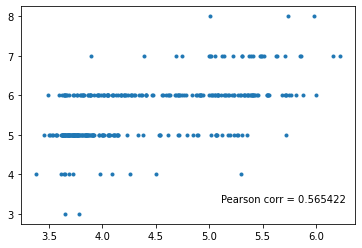

In [9]:
# load the best model
best_trained_model = ANNModel(X_train.shape[1], 1, [best_trial.config['h1'], 
                              best_trial.config['h2'], best_trial.config['h3']], 
                              p = best_trial.config['p'])
best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

# make predictions
best_trained_model.eval()
with torch.no_grad():
    y_val = best_trained_model(X_test)
    loss = custom_loss(y_val, y_test, None, 'corr')

fig, ax = plt.subplots()
ax.plot(y_val, y_test, '.')
ax.text(0.6,0.1,f'Pearson corr = {-loss:.6f}',transform = ax.transAxes) # The value differs from above due to no dropout.